# Initialize Libraries

In [51]:
#python helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import warnings
warnings.filterwarnings('ignore')

#model metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay,roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

#scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV

#data import
from ucimlrepo import fetch_ucirepo 


# Functions

In [2]:
#train test and scale function
def train_test_scale_function(data,technique):
    #train test split
    X=data.drop(columns="quality")
    y=data["quality"] - data["quality"].min()  #need to start at 0 for XG Boost
    X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42)

    #scaler fitting
    ss=StandardScaler().fit(X_train)
    mm=MinMaxScaler(feature_range=(0,1)).fit(X_train)

    if technique in ["svm","knn","logr","linr","ridge","lasso"]:
        # Standard scaling for SVM, KNN, Logistic Regression, and liner regressions
        X_train_scaled=ss.transform(X_train)
        X_test_scaled=ss.transform(X_test)
    elif technique in ["gb","mbg","nbm","nbg"]:
        #MinMax scaling for gradient boost and naive bayes models
        X_train_scaled=mm.transform(X_train)
        X_test_scaled=mm.transform(X_test)
    else:
        #No scaling for other techniques (e.g., tree based models)
        X_train_scaled=X_train
        X_test_scaled=X_test

    return X_train_scaled, X_test_scaled, y_train, y_test

In [3]:
#classifier function
def classifier_function(data, technique):
    #model mapping
    model_mapping={
        "rf" : RandomForestClassifier,
        "gb" : GradientBoostingClassifier,
        "svm" : SVC,
        "knn" : KNeighborsClassifier,
        "dt" : DecisionTreeClassifier,
        "ert" : ExtraTreesClassifier,
        "ab" : AdaBoostClassifier,
        "xgb" : XGBClassifier,
        "nbg" : GaussianNB,
        "nbm" : MultinomialNB,
        "nbb" : BernoulliNB,
        "logr" : LogisticRegression,
        "linr" : LinearRegression,
        "ridge" : Ridge,
        "lasso" : Lasso
    }

    #data
    X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(data, technique)

    #commands
    model_class=model_mapping.get(technique)
    if technique in ["rf","gb","dt","ert","ab","logr","ridge","lasso"]:
        model_instance=model_class(random_state=42)
    elif technique=="svm":
        model_instance=model_class(random_state=42,kernel="rbf")
    elif technique in ["knn","xgb","nbg","nbm","nbb","linr"]:
        model_instance=model_class()
    else:
        raise ValueError(f"Unknown model type: {technique}") 
    

    model_instance.fit(X_train_scaled,y_train)
    predictions=model_instance.predict(X_test_scaled)
    
    if technique in ["linr", "ridge", "lasso"]:
        mse=mean_squared_error(y_test,predictions)
        r2=r2_score(y_test,predictions)
        model_train_score=None
        model_test_score=None
    else:
        mse=None
        r2=None
        model_train_score=model_instance.score(X_train_scaled,y_train)
        model_test_score=model_instance.score(X_test_scaled,y_test)
        #classification=classification_report(y_test,predictions)
 
    return model_train_score,model_test_score,mse,r2


In [4]:
#function to produce metrics table
def model_report_function(data):
    # Store classifier results in a dictionary
    classifier_results = {
        "Classifier": ["Random Forest", "Gradient Boost", "SVM", "KNN", "Decision Tree","Extremely Random Tree", "Adaptive Boost", "XG Boost","Naive Bayes Gaussian", "Naive Bayes Multinomial", "Naive Bayes Bernoulli","Logistic Regression"],
        "Training Accuracy": [],
        "Test Accuracy": []
    }

    # Compute accuracy metrics for classifiers
    for model_key in ["rf", "gb", "svm", "knn", "dt", "ert", "ab", "xgb", "nbg", "nbm", "nbb", "logr"]:
        training_acc, test_acc, _, _ = classifier_function(data, model_key)
        classifier_results["Training Accuracy"].append(training_acc)
        classifier_results["Test Accuracy"].append(test_acc)

    # Store regression results in a separate dictionary
    regression_results = {
        "Regressor": ["Linear Regression", "Ridge", "Lasso"],
        "MSE": [], "R Squared": []
    }

    # Compute regression metrics
    for model_key in ["linr", "ridge", "lasso"]:
        _, _, mse, r_squared = classifier_function(data, model_key)
        regression_results["MSE"].append(mse)
        regression_results["R Squared"].append(r_squared)

    # Convert dictionaries to DataFrames and sort
    classifier_df = pd.DataFrame(classifier_results).sort_values("Test Accuracy", ascending=False)
    regression_df = pd.DataFrame(regression_results).sort_values("MSE", ascending=False)

    return classifier_df,regression_df

# Datasets

In [5]:
#Load dataset
wine_data = pd.read_csv('https://archive.ics.uci.edu/static/public/186/data.csv')

display(wine_data.head())
wine_data.info()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [28]:
#encode wine_data color (0 for red, 1 for white)
wine_data_encoded=wine_data.copy()
wine_data_encoded["color"]=np.where(wine_data_encoded["color"]=="red", 0,
                                    np.where(wine_data_encoded["color"]=="white", 1, 100))

#make data subsets
wine_data_red=wine_data[wine_data["color"]=="red"].drop(columns="color")
wine_data_white=wine_data[wine_data["color"]=="white"].drop(columns="color")

#data with less quality classes
wine_data_red_cat=wine_data_red.copy()
wine_data_red_cat["quality"]=np.where(wine_data_red_cat["quality"] <=5, 1,
                                          np.where(wine_data_red_cat["quality"]<=7,2, 3))

wine_data_white_cat=wine_data_white.copy()
wine_data_white_cat["quality"]=np.where(wine_data_white_cat["quality"] <=5, 1,
                                          np.where(wine_data_white_cat["quality"]<=7,2, 3))

wine_data_encoded_cat=wine_data_encoded.copy()
wine_data_encoded_cat["quality"]=np.where(wine_data_encoded_cat["quality"] <=5, 1,
                                          np.where(wine_data_encoded_cat["quality"]<=7,2, 3))

#all colors without level 3
wine_data_encoded_cat_reduced=wine_data_encoded_cat[wine_data_encoded_cat["quality"]!=3]


print("------------------------Wine Encoded--------------------")
display(wine_data_encoded.head())
print(f"Wine Data Unique Colors {wine_data_encoded["color"].unique()}")
print("------------------------Red and White Data--------------------")
display(wine_data_red.head())
display(wine_data_white.head())
print("------------------------Quality Categorized Data--------------------")
display(wine_data_red_cat.head())
print(f"Red Wine Unique Qualities: {wine_data_red_cat["quality"].unique()}\nRed Wine Shape: {wine_data_red_cat.shape}")
display(wine_data_white_cat.head())
print(f"White Wine Unique Qualities: {wine_data_white_cat["quality"].unique()}\nWhite Wine Shape: {wine_data_white_cat.shape}")
display(wine_data_encoded_cat.head())
print(f"All Wine Unique Qualities: {wine_data_encoded_cat["quality"].unique()}\nAll Wine Shape: {wine_data_encoded_cat.shape}")
print("--------------------Quality Categorized Data, 2-levels----------------")
display(wine_data_encoded_cat_reduced.head())
print(f"All Wine Unique Qualities: {wine_data_encoded_cat_reduced["quality"].unique()}\nAll Wine Shape: {wine_data_encoded_cat_reduced.shape}")


------------------------Wine Encoded--------------------


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


Wine Data Unique Colors [0 1]
------------------------Red and White Data--------------------


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
1599,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1600,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
1601,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
1602,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
1603,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


------------------------Quality Categorized Data--------------------


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1


Red Wine Unique Qualities: [1 2 3]
Red Wine Shape: (1599, 12)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
1599,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,2
1600,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,2
1601,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,2
1602,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2
1603,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2


White Wine Unique Qualities: [2 1 3]
White Wine Shape: (4898, 12)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,2,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,0


All Wine Unique Qualities: [1 2 3]
All Wine Shape: (6497, 13)
--------------------Quality Categorized Data, 2-levels----------------


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,2,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,0


All Wine Unique Qualities: [1 2]
All Wine Shape: (6299, 13)


# Investigate data

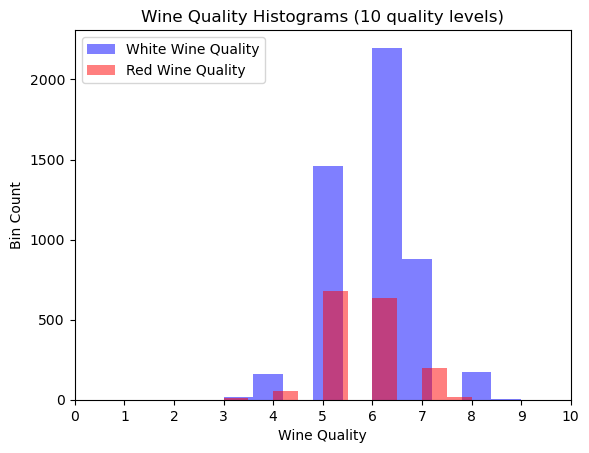

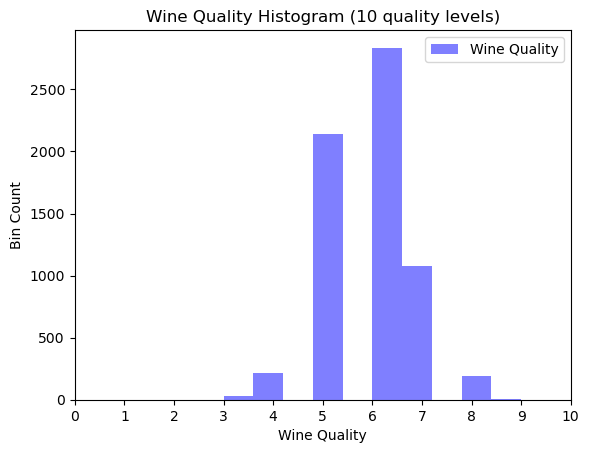

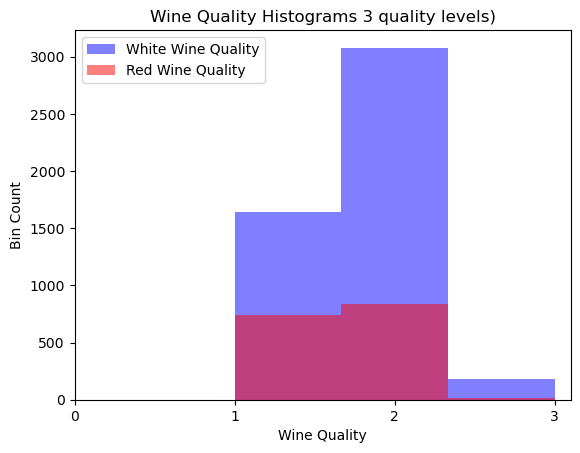

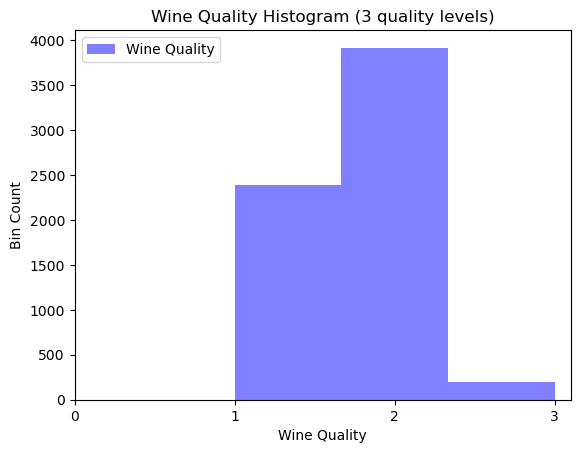

In [23]:
#view the output histograms for each wine color
fig1, ax=plt.subplots()
ax.hist(wine_data_white["quality"],bins=10, alpha=0.5, label="White Wine Quality", color="blue")
ax.hist(wine_data_red["quality"],bins=10, alpha=0.5, label="Red Wine Quality", color="red")
ax.set_xlabel("Wine Quality")
ax.set_ylabel("Bin Count")
ax.set_title("Wine Quality Histograms (10 quality levels)")
ax.set_xticks(range(0,11,1))
ax.legend()
plt.show()

#view histogram for wine quality regardless of color
fig2, ax=plt.subplots()
ax.hist(wine_data["quality"],bins=10, alpha=0.5, label="Wine Quality", color="blue")
ax.set_xlabel("Wine Quality")
ax.set_ylabel("Bin Count")
ax.set_title("Wine Quality Histogram (10 quality levels)")
ax.set_xticks(range(0,11,1))
ax.legend()
plt.show()


#view histogram for both each color only using 3 quality categories
fig3, ax=plt.subplots()
ax.hist(wine_data_white_cat["quality"],bins=3, alpha=0.5, label="White Wine Quality", color="blue")
ax.hist(wine_data_red_cat["quality"],bins=3, alpha=0.5, label="Red Wine Quality", color="red")
ax.set_xlabel("Wine Quality")
ax.set_ylabel("Bin Count")
ax.set_title("Wine Quality Histograms 3 quality levels)")
ax.set_xticks(range(0,4,1))
ax.legend()
plt.show()

#view histogram for wine quality regardless of color with 3 quality levels
#view histogram for wine quality regardless of color
fig4, ax=plt.subplots()
ax.hist(wine_data_encoded_cat["quality"],bins=3, alpha=0.5, label="Wine Quality", color="blue")
ax.set_xlabel("Wine Quality")
ax.set_ylabel("Bin Count")
ax.set_title("Wine Quality Histogram (3 quality levels)")
ax.set_xticks(range(0,4,1))
ax.legend()
plt.show()

In [9]:
#check for nulls and the data types
wine_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   int32  
dtypes: float64(11), int32(1), int64(1)
memory usage: 634.6 KB


In [10]:
# Check values
wine_data_encoded.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


In [11]:
# check for correlations
wine_data_encoded.corr().round(2)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
fixed_acidity,1.00,0.22,0.32,-0.11,0.30,-0.28,-0.33,0.46,-0.25,0.30,-0.10,-0.08,-0.49
volatile_acidity,0.22,1.00,-0.38,-0.20,0.38,-0.35,-0.41,0.27,0.26,0.23,-0.04,-0.27,-0.65
citric_acid,0.32,-0.38,1.00,0.14,0.04,0.13,0.20,0.10,-0.33,0.06,-0.01,0.09,0.19
residual_sugar,-0.11,-0.20,0.14,1.00,-0.13,0.40,0.50,0.55,-0.27,-0.19,-0.36,-0.04,0.35
chlorides,0.30,0.38,0.04,-0.13,1.00,-0.20,-0.28,0.36,0.04,0.40,-0.26,-0.20,-0.51
free_sulfur_dioxide,-0.28,-0.35,0.13,0.40,-0.20,1.00,0.72,0.03,-0.15,-0.19,-0.18,0.06,0.47
total_sulfur_dioxide,-0.33,-0.41,0.20,0.50,-0.28,0.72,1.00,0.03,-0.24,-0.28,-0.27,-0.04,0.70
density,0.46,0.27,0.10,0.55,0.36,0.03,0.03,1.00,0.01,0.26,-0.69,-0.31,-0.39
pH,-0.25,0.26,-0.33,-0.27,0.04,-0.15,-0.24,0.01,1.00,0.19,0.12,0.02,-0.33
sulphates,0.30,0.23,0.06,-0.19,0.40,-0.19,-0.28,0.26,0.19,1.00,-0.00,0.04,-0.49


# Modeling

### Trying various models

In [29]:
# Both colors in 1 dataset with the color encoded and 9 quality classes
display(model_report_function(wine_data_encoded)[0].round(3))
display(model_report_function(wine_data_encoded)[1].round(3))


,Classifier,Training Accuracy,Test Accuracy
0,Random Forest,1.000,0.682
5,Extremely Random Tree,1.000,0.666
7,XG Boost,0.989,0.665
4,Decision Tree,1.000,0.599
1,Gradient Boost,0.707,0.583
2,SVM,0.610,0.564
3,KNN,0.706,0.543
11,Logistic Regression,0.550,0.534
9,Naive Bayes Multinomial,0.432,0.458
10,Naive Bayes Bernoulli,0.441,0.449


,Regressor,MSE,R Squared
2,Lasso,0.743,-0.000
0,Linear Regression,0.546,0.266
1,Ridge,0.545,0.266


In [72]:
# Both colors in 1 dataset with the color encoded and 3 quality classes
display(model_report_function(wine_data_encoded_cat)[0].round(3))
display(model_report_function(wine_data_encoded_cat)[1].round(3))

,Classifier,Training Accuracy,Test Accuracy
5,Extremely Random Tree,1.000,0.804
0,Random Forest,1.000,0.798
7,XG Boost,0.994,0.777
1,Gradient Boost,0.800,0.742
2,SVM,0.768,0.734
4,Decision Tree,1.000,0.721
3,KNN,0.816,0.708
11,Logistic Regression,0.718,0.697
6,Adaptive Boost,0.698,0.678
8,Naive Bayes Gaussian,0.623,0.620


,Regressor,MSE,R Squared
2,Lasso,0.276,-0.00
0,Linear Regression,0.215,0.22
1,Ridge,0.215,0.22


In [73]:
#Red data only, 9 quality categories
display(model_report_function(wine_data_red)[0].round(3))
display(model_report_function(wine_data_red)[1].round(3))


,Classifier,Training Accuracy,Test Accuracy
5,Extremely Random Tree,1.000,0.692
7,XG Boost,1.000,0.680
0,Random Forest,1.000,0.670
1,Gradient Boost,0.900,0.638
2,SVM,0.671,0.628
11,Logistic Regression,0.614,0.588
4,Decision Tree,1.000,0.582
3,KNN,0.713,0.578
8,Naive Bayes Gaussian,0.570,0.545
6,Adaptive Boost,0.560,0.522


,Regressor,MSE,R Squared
2,Lasso,0.620,-0.002
1,Ridge,0.388,0.372
0,Linear Regression,0.388,0.372


In [74]:
#Red data only with 3 quality classes
display(model_report_function(wine_data_red_cat)[0].round(3))
display(model_report_function(wine_data_red_cat)[1].round(3))

,Classifier,Training Accuracy,Test Accuracy
7,XG Boost,1.000,0.790
5,Extremely Random Tree,1.000,0.785
0,Random Forest,1.000,0.775
1,Gradient Boost,0.892,0.755
2,SVM,0.791,0.748
8,Naive Bayes Gaussian,0.715,0.728
4,Decision Tree,1.000,0.720
11,Logistic Regression,0.741,0.712
3,KNN,0.809,0.685
6,Adaptive Boost,0.692,0.680


,Regressor,MSE,R Squared
2,Lasso,0.271,-0.003
0,Linear Regression,0.193,0.288
1,Ridge,0.193,0.288


In [75]:
#white wine data with 9 quality classes
display(model_report_function(wine_data_white)[0].round(3))
display(model_report_function(wine_data_white)[1].round(3))

,Classifier,Training Accuracy,Test Accuracy
5,Extremely Random Tree,1.000,0.687
0,Random Forest,1.000,0.672
7,XG Boost,0.998,0.664
4,Decision Tree,1.000,0.597
1,Gradient Boost,0.734,0.568
2,SVM,0.622,0.558
3,KNN,0.695,0.542
11,Logistic Regression,0.551,0.526
9,Naive Bayes Multinomial,0.450,0.444
10,Naive Bayes Bernoulli,0.450,0.444


,Regressor,MSE,R Squared
2,Lasso,0.778,-0.002
1,Ridge,0.565,0.273
0,Linear Regression,0.565,0.273


In [76]:
#white wine data with 3 quality classes
display(model_report_function(wine_data_white_cat)[0].round(3))
display(model_report_function(wine_data_white_cat)[1].round(3))

,Classifier,Training Accuracy,Test Accuracy
5,Extremely Random Tree,1.000,0.812
0,Random Forest,1.000,0.805
7,XG Boost,0.997,0.797
1,Gradient Boost,0.813,0.751
2,SVM,0.775,0.748
4,Decision Tree,1.000,0.736
3,KNN,0.816,0.724
11,Logistic Regression,0.718,0.711
6,Adaptive Boost,0.702,0.697
8,Naive Bayes Gaussian,0.666,0.673


,Regressor,MSE,R Squared
2,Lasso,0.276,-0.001
1,Ridge,0.211,0.235
0,Linear Regression,0.211,0.235


In [31]:
# Both colors in 1 dataset with the color encoded and 2 quality classes
display(model_report_function(wine_data_encoded_cat_reduced)[0].round(3))
display(model_report_function(wine_data_encoded_cat_reduced)[1].round(3))

,Classifier,Training Accuracy,Test Accuracy
5,Extremely Random Tree,1.000,0.815
0,Random Forest,1.000,0.813
7,XG Boost,0.986,0.805
4,Decision Tree,1.000,0.780
1,Gradient Boost,0.805,0.766
2,SVM,0.784,0.762
3,KNN,0.829,0.761
6,Adaptive Boost,0.762,0.740
11,Logistic Regression,0.733,0.731
8,Naive Bayes Gaussian,0.676,0.657


,Regressor,MSE,R Squared
2,Lasso,0.232,-0.001
0,Linear Regression,0.182,0.218
1,Ridge,0.182,0.218


### In depth Analysis on models

In [84]:
#extremely random trees
#grid search

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

etc = ExtraTreesClassifier(random_state=42)
grid_search = GridSearchCV(estimator=etc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


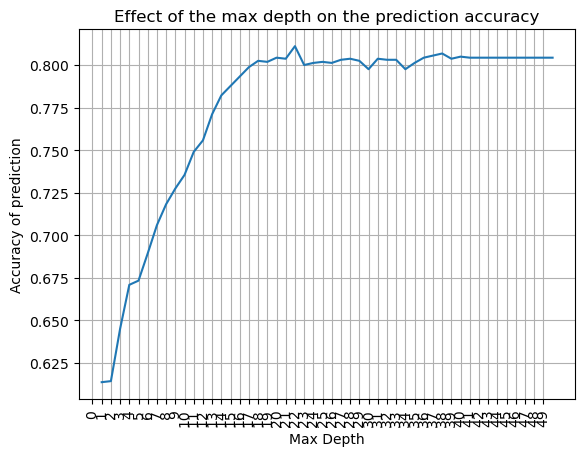

In [129]:
#max depth tuning around 30

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


n=50
accuracy=[]
for i in range(n):
    ert_model=ExtraTreesClassifier(random_state=42, max_depth=i+1)
    ert_model=ert_model.fit(X_train_scaled,y_train)
    predictions=ert_model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test,predictions))

plt.plot(range(1,n+1), accuracy)
plt.xticks(ticks=range(n), rotation=90)
plt.grid(True)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy of prediction")
plt.title("Effect of the max depth on the prediction accuracy")
plt.show()

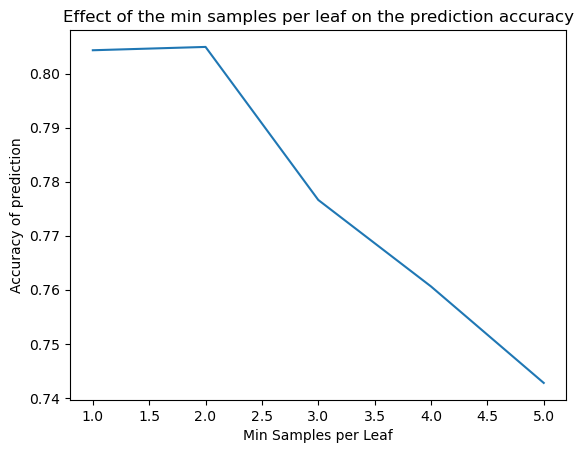

In [118]:
#min_samples_leaf around 1

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


n=5
accuracy=[]
for i in range(n):
    ert_model=ExtraTreesClassifier(random_state=42, min_samples_leaf=i+1)
    ert_model=ert_model.fit(X_train_scaled,y_train)
    predictions=ert_model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test,predictions))

plt.plot(range(1,n+1), accuracy)
plt.xlabel("Min Samples per Leaf")
plt.ylabel("Accuracy of prediction")
plt.title("Effect of the min samples per leaf on the prediction accuracy")
plt.show()

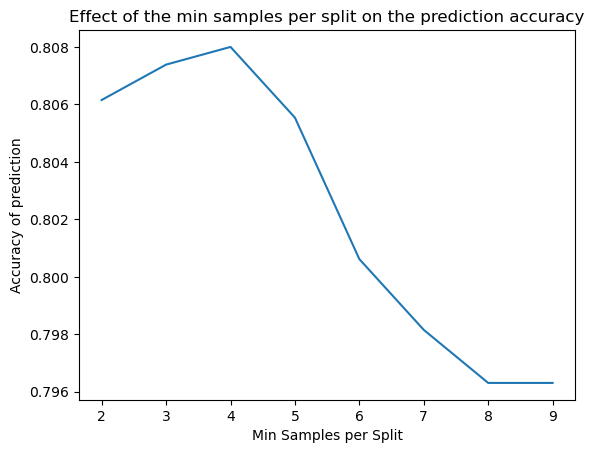

In [122]:
#tuning around min_sample_split

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


n=10
accuracy=[]
for i in range(2,n,1):
    ert_model=ExtraTreesClassifier(random_state=42, min_samples_split=i+1)
    ert_model=ert_model.fit(X_train_scaled,y_train)
    predictions=ert_model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test,predictions))

plt.plot(range(2,n), accuracy)
plt.xlabel("Min Samples per Split")
plt.ylabel("Accuracy of prediction")
plt.title("Effect of the min samples per split on the prediction accuracy")
plt.show()

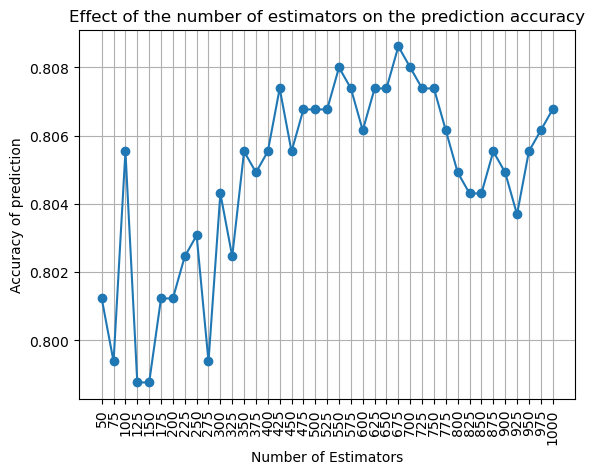

In [127]:
#tuning around n_estimators

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


n=1000
accuracy=[]
for i in range(50,n+1,25):
    ert_model=ExtraTreesClassifier(random_state=42, n_estimators=i+1)
    ert_model=ert_model.fit(X_train_scaled,y_train)
    predictions=ert_model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test,predictions))

plt.plot(range(50,n+1,25), accuracy, marker="o")
plt.xticks(ticks=range(50,n+1,25), rotation=90)
plt.grid(True)
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy of prediction")
plt.title("Effect of the number of estimators on the prediction accuracy")
plt.show()

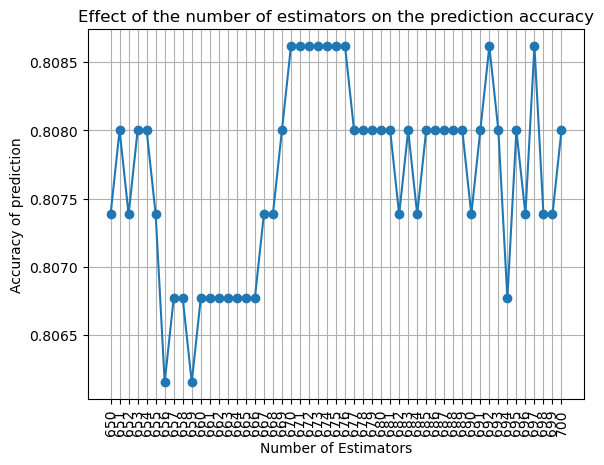

In [130]:
#tune around 675 for n estimators
X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


n=700
accuracy=[]
for i in range(650,n+1,1):
    ert_model=ExtraTreesClassifier(random_state=42, n_estimators=i+1)
    ert_model=ert_model.fit(X_train_scaled,y_train)
    predictions=ert_model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test,predictions))

plt.plot(range(650,n+1,1), accuracy, marker="o")
plt.xticks(ticks=range(650,n+1,1), rotation=90)
plt.grid(True)
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy of prediction")
plt.title("Effect of the number of estimators on the prediction accuracy")
plt.show()

In [35]:
#extremely random trees
#metrics for best parameters

#data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")

#initialize model
#ert_model=ExtraTreesClassifier(random_state=42, max_depth=22, max_features="sqrt", min_samples_leaf=2, min_samples_split= 4, n_estimators=675)

ert_model=ExtraTreesClassifier(random_state=42, max_depth=30, max_features="sqrt", min_samples_leaf=1, min_samples_split= 5, n_estimators=675)

#fit model
ert_model.fit(X_train_scaled,y_train)

#feature importance
importance=ert_model.feature_importances_
importance_df=pd.DataFrame({
    "Feature" : X_train_scaled.columns,
    "Importance" : importance}).sort_values(by="Importance", ascending=False)

display(importance_df)

#classification report
predictions=ert_model.predict(X_test_scaled)
cr=classification_report(y_test,predictions)
print(cr)

#confusion matrix
cm=confusion_matrix(y_test,predictions)
classes=["Class 1","Class 2", "Class 3"]
cm_df=pd.DataFrame(cm,index=classes,columns=classes)

display(cm_df)


,Feature,Importance
10,alcohol,0.183914
1,volatile_acidity,0.119110
7,density,0.085569
5,free_sulfur_dioxide,0.081450
6,total_sulfur_dioxide,0.079770
2,citric_acid,0.079708
9,sulphates,0.077677
3,residual_sugar,0.071088
8,pH,0.070462
4,chlorides,0.070039


              precision    recall  f1-score   support

           0       0.76      0.75      0.75       584
           1       0.83      0.86      0.85       997
           2       1.00      0.30      0.46        44

    accuracy                           0.81      1625
   macro avg       0.86      0.64      0.69      1625
weighted avg       0.81      0.81      0.80      1625



,Class 1,Class 2,Class 3
Class 1,436,148,0
Class 2,136,861,0
Class 3,0,31,13


### feature engineering

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:2.797e-224 t=-3.331e+01


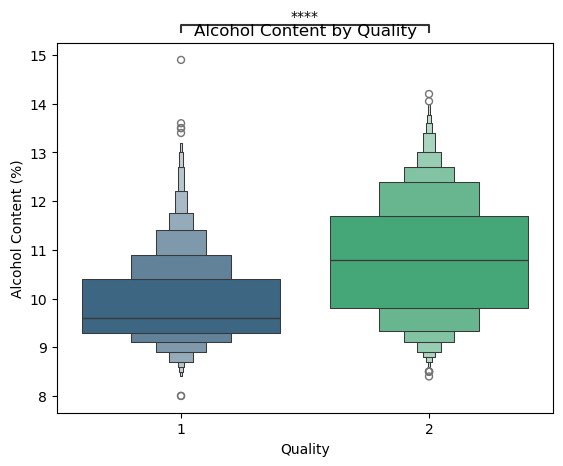

In [52]:
#plots to try and investigate levels 1 and 2
data=wine_data_encoded_cat_reduced.copy()

fig1, ax=plt.subplots()
sns.boxenplot(data=data, x="quality", y="alcohol", palette="viridis")
box_pairs = [(1, 2)]
annotator = Annotator(ax, box_pairs, data=data, x="quality", y="alcohol")
annotator.configure(test="t-test_ind", text_format="star", loc="outside")
annotator.apply_and_annotate()  
ax.set_xlabel("Quality")
ax.set_ylabel("Alcohol Content (%)")
ax.set_title("Alcohol Content by Quality")
plt.show()
